# Method 1: 

# Define area and download from GBDX 

In [297]:
bbox = [115.179, -8.734, 115.183, -8.729 ]

x_min = bbox[0]
x_max = bbox[2]
y_min = bbox[1]
y_max = bbox[3]


file_name = 'Situ_Denpasar_harbor_no_acomp.tif'

In [310]:
# Import image and convert image to UTM projection

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline



catalog_id = env.inputs.get('catalog_id', '104001005876CA00')







# image = CatalogImage(catalog_id, band_type="MS", bbox=bbox, pansharpen = True, acomp=False)

# acquisitionDate = image.metadata["image"]["acquisitionDate"]

# print("  taken on {}".format(acquisitionDate))


# image.plot(w=10, h=10)

# # Transform dask array to array
# image_array = image.read()
# data = image_array

# image.geotiff(path=file_name)

# Method 2:

## Predefined raster and shapes

In [377]:
# load libraries
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.geometry import shape

import fiona

In [379]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob
from pprint import pprint 

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/*.shp'
shape_files = glob.glob(shape_file_path)
path_water = shape_files[0]
nr_search = path_water.split('/')[-1].split('_')[0]

print(cwd)
print('-------------------------------------')
pprint(shape_files)
print('-------------------------------------')
print(path_water)
print(nr_search)

/home/chris/Documents/GreenCityWatch/GCW_toolkit/03_create_classification
-------------------------------------
['../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/003_Jakarta_hand_water.shp',
 '../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/001_Jakarta_hand_water.shp',
 '../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/001_Jakarta_hand_water_buffer.shp',
 '../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/000_Jakarta_hand_water.shp',
 '../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/034_Jakarta_hand_water.shp']
-------------------------------------
../../TreeTect/data/shapefiles_waterbodies_osm/hand_water/003_Jakarta_hand_water.shp
003


In [380]:
# find files in shapefile folder
shape_file_path = '../../TreeTect/data/shapefiles_waterbodies_osm/hand_nonwater/{}*.shp'.format(nr_search)
shape_files = glob.glob(shape_file_path)
path_nonwater = shape_files[0]


print(cwd)
print('-------------------------------------')
pprint(shape_files)
print('-------------------------------------')
print(path_nonwater)


/home/chris/Documents/GreenCityWatch/GCW_toolkit/03_create_classification
-------------------------------------
['../../TreeTect/data/shapefiles_waterbodies_osm/hand_nonwater/003_Jakarta_hand_nonwater.shp']
-------------------------------------
../../TreeTect/data/shapefiles_waterbodies_osm/hand_nonwater/003_Jakarta_hand_nonwater.shp


In [381]:
shape_list = []

for pol in fiona.open(path_water):
    
    if pol['geometry'] != None:
        print(pol['geometry']['type'])
        shape_list.append(pol)

Polygon


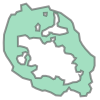

In [382]:
# load polygons

shape_crs = fiona.open(path_water)
water_Multi = MultiPolygon([shape(pol['geometry']) for pol in shape_list]) 

min_x, min_y, max_x, max_y = water_Multi.bounds

water_Multi

In [383]:
# get a projected coordinate system for plotting
EPSG = 32700-round((45+min_y)/90,0)*100+round((183+min_x)/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

UTM_EPSG_code

'EPSG:32748'

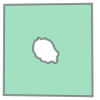

In [384]:
# load polygons

shape_crs = fiona.open(path_nonwater)
non_water_Multi = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path_nonwater)]) 

min_x, min_y, max_x, max_y = non_water_Multi.bounds

non_water_Multi

In [385]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds

    points = []

    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points

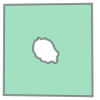

In [386]:
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:4326'))


non_water_Multi_wgs = transform(project, non_water_Multi)
water_Multi_wgs = transform(project, water_Multi)

non_water_Multi_wgs

In [387]:
## check data!!
# !pip install folium


import folium


m = folium.Map([water_Multi_wgs.centroid.y, water_Multi_wgs.centroid.x],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB') #, name = 'cartocdn')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


folium.Choropleth(water_Multi, name = 'Training set water').add_to(m)

folium.Choropleth(non_water_Multi_wgs, name = 'Training set water').add_to(m)


# folium.Choropleth(setu_smooth, name = 'Smooth setu delineation').add_to(m)



# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 


# I can add marker one by one on the map
# for i in range(0,len(data)):
#     folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)

for point in points_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x]).add_to(m)
    
    
for point in points_non_water:
    #point_wgs = transform(project, point)
    folium.Marker([point.y, point.x]).add_to(m)

folium.LayerControl().add_to(m)


In [388]:
# view folium map

# m

In [389]:
# find files in shapefile folder
shape_file_path = '../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_{}*.tif'.format(nr_search)
shape_files = glob.glob(shape_file_path)
file_path = shape_files[0]


print(cwd)
print('-------------------------------------')
pprint(shape_files)
print('-------------------------------------')
print(file_path)

/home/chris/Documents/GreenCityWatch/GCW_toolkit/03_create_classification
-------------------------------------
['../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_003_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.tif']
-------------------------------------
../../TreeTect/data/rasters_waterbodies_osm/Jakarta/Jakarta_003_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.tif


# all pixels method

In [390]:
import rasterio
from rasterio import mask

dataset = rasterio.open(file_path)



In [391]:
import matplotlib.pyplot as plt

In [392]:
bands,x,y = dataset.read().shape

In [393]:
array_dataset = dataset.read().reshape([x*y,8])

In [394]:
non_water_pixels = mask.mask(dataset, non_water_Multi_wgs, invert=False)[0]

b,x,y = non_water_pixels.shape

non_water_pixels_reshape = non_water_pixels.reshape([x*y,8])[:,0]

non_water_pixels_index = non_water_pixels_reshape == 0


In [395]:
# Create dataframe from clicked values

import pandas as pd

df_bands = pd.DataFrame(array_dataset)

df_bands['label'] = 'water'
df_bands.loc[non_water_pixels_index, ['label']] = 'non_water'

In [396]:
sum(df_bands['label'] == 'water') + sum(df_bands['label'] == 'non_water')

426213

In [397]:
df = df_bands

# sample method


In [401]:
def get_values_for_points(dataset, points):

    bands_save = []
    x_save = []
    y_save = []
    
    data_array = dataset.read()

    for i in range(n_points):
        x = points[i].x
        y = points[i].y

        x_save.append(x)
        y_save.append(y)

        index = dataset.index(x, y)

        band_values = data_array[:,index[0],index[1]]

        bands_save.append(band_values)

#         print(band_values)
        
    return bands_save, x_save, y_save

In [402]:
import random

n_points = 1000

points_water = random_points_within(water_Multi_wgs, n_points)

points_non_water = random_points_within(non_water_Multi_wgs, n_points)

In [403]:
bands_save, x_save, y_save = get_values_for_points(dataset, points_water)

bands_save_n, x_save_n, y_save_n = get_values_for_points(dataset, points_non_water)

In [404]:
# Create dataframe from clicked values

import pandas as pd

df_bands = pd.DataFrame(bands_save)

df_bands['x'] = x_save
df_bands['y'] = y_save
df_bands['label'] = 'water'

In [405]:
df_bands_n = pd.DataFrame(bands_save_n)

df_bands_n['x'] = x_save_n
df_bands_n['y'] = y_save_n
df_bands_n['label'] = 'non_water'

In [406]:
frames = [df_bands, df_bands_n]

#concatenate dataframes
df = pd.concat(frames, sort=False)

# Export training data

In [407]:
df.sample(10)

,0,1,2,3,4,5,6,7,x,y,label
2,2050.0,1807.0,1553.0,1440.0,1361.0,1413.0,1552.0,1309.0,106.833870,-6.197213,non_water
271,2001.0,1766.0,1532.0,1410.0,1321.0,1542.0,1834.0,1540.0,106.833860,-6.199092,non_water
374,1978.0,1709.0,1472.0,1315.0,1197.0,1497.0,1980.0,1664.0,106.835808,-6.196739,non_water
119,1950.0,1709.0,1490.0,1355.0,1251.0,1612.0,2151.0,1837.0,106.834574,-6.198387,non_water
639,2076.0,1874.0,1668.0,1609.0,1554.0,1601.0,1754.0,1426.0,106.833510,-6.196843,non_water
90,1933.0,1694.0,1455.0,1317.0,1227.0,1382.0,1672.0,1340.0,106.834524,-6.199197,non_water
900,2047.0,1819.0,1626.0,1475.0,1363.0,1308.0,1305.0,1066.0,106.834614,-6.197779,water
872,1967.0,1715.0,1454.0,1347.0,1254.0,1329.0,1429.0,1217.0,106.835891,-6.196633,non_water
336,1913.0,1661.0,1461.0,1287.0,1172.0,1758.0,2556.0,2168.0,106.835262,-6.197961,non_water
41,2037.0,1808.0,1605.0,1447.0,1350.0,1294.0,1311.0,1072.0,106.834803,-6.197776,water


In [408]:
file_name = file_path.split('/')[-1].split('.')[0]

In [409]:
import datetime

NOW = datetime.datetime.now()

csv_filename = "../../TreeTect/data/trainings_data_waterbodies/data_non_acomp_{}_{}.csv".format(file_name, NOW)

df.to_csv(csv_filename)

print(csv_filename)

../../TreeTect/data/trainings_data_waterbodies/data_non_acomp_Jakarta_003_pansharpen_True_2018-09-13_03:30_1030010085B5FC00_2020-03-09 14:56:36.025705.csv


# In case of emergency

In [54]:
# Save dataframe as csv file and create download link
from IPython.display import HTML
import base64  
import pandas as pd  
import datetime

NOW = datetime.datetime.now()

def create_download_link(df, title = "Download CSV file", 
                         filename = "data_{}_{}.csv".format(file_name, NOW)):  
    
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)